In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'carinsuranceclaimprediction-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2636290%2F4511133%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240314%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240314T155527Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D46d4e94322b1684662844f7d66381c89c0f9b22bd82ef95157964146e7f320b5f35ff893687f7ae78a815ddbf0da717b9bb25700281c589efa8fbac17f7da48ba29847aacba513029b006dc71ecd904164ea877f674f58acfe7199479f6ab479dae0924bd18a912edfb44ee17c666452de505367ade9f71001c1cfde54dbb781bb5e926e52212da43048b0a1130648a436eb01a555a9dfc01ec0b59a1e7e9f67d07e700d49450d471c613c9b9f72a95f7bbb5b87a1557ad069b39f2b9fdec982a1ead5e6692361dde14bf96930cd0435603f360653f09d325c6c812fbde824a20c4433f7bbf6000887a9019532f1a0d50c5bb28461092e035c7734f6e5b188cf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2051639 bytes downloaded
Downloaded and uncompressed: carinsuranceclaimprediction-classification
Data source import complete.


# Car Insurance Claim Prediction

#### Predict whether the policyholder will file a claim in the next 6 months or not.

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
data=pd.read_csv("/kaggle/input/carinsuranceclaimprediction-classification/train.csv")

In [ ]:
data

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

# Size of the data

In [ ]:
data.shape

(58592, 44)

# Datatypes

In [ ]:
data.dtypes

policy_id                            object
policy_tenure                       float64
age_of_car                          float64
age_of_policyholder                 float64
area_cluster                         object
population_density                    int64
make                                  int64
segment                              object
model                                object
fuel_type                            object
max_torque                           object
max_power                            object
engine_type                          object
airbags                               int64
is_esc                               object
is_adjustable_steering               object
is_tpms                              object
is_parking_sensors                   object
is_parking_camera                    object
rear_brakes_type                     object
displacement                          int64
cylinder                              int64
transmission_type               

### OBJECT DATA TYPES

In [ ]:


data.drop(['policy_id','make','model'],axis=1,inplace=True)

In [ ]:
object_data=data.select_dtypes(include= [object])

In [ ]:

object_data

,area_cluster,segment,fuel_type,max_torque,max_power,engine_type,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,...,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,C1,A,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,No,Yes,...,No,No,No,No,No,Yes,No,No,No,Yes
1,C2,A,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,No,Yes,...,No,No,No,No,No,Yes,No,No,No,Yes
2,C3,A,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,No,Yes,...,No,No,No,No,No,Yes,No,No,No,Yes
3,C4,C1,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,Yes,Yes,No,Yes,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,C5,A,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,No,No,No,No,...,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,C8,A,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,No,No,No,No,...,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes
58588,C14,A,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,No,Yes,...,No,No,No,No,No,Yes,No,No,No,Yes
58589,C5,A,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,No,No,No,Yes,...,No,No,No,No,No,Yes,No,No,No,Yes
58590,C8,B2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,No,Yes,No,Yes,...,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [ ]:
numerical_data = data.select_dtypes(include=['float64','int64'])

In [ ]:
numerical_data

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
0,0.515874,0.05,0.644231,4990,2,796,3,5,4.6,3445,1515,1475,1185,0,0
1,0.672619,0.02,0.375000,27003,2,796,3,5,4.6,3445,1515,1475,1185,0,0
2,0.841110,0.02,0.384615,4076,2,796,3,5,4.6,3445,1515,1475,1185,0,0
3,0.900277,0.11,0.432692,21622,2,1197,4,5,4.8,3995,1735,1515,1335,2,0
4,0.596403,0.11,0.634615,34738,2,999,3,5,5.0,3731,1579,1490,1155,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.355089,0.13,0.644231,8794,2,999,3,5,5.0,3731,1579,1490,1155,2,0
58588,1.199642,0.02,0.519231,7788,2,796,3,5,4.6,3445,1515,1475,1185,0,0
58589,1.162273,0.05,0.451923,34738,2,796,3,5,4.6,3445,1515,1475,1185,0,0
58590,1.236307,0.14,0.557692,8794,2,1197,4,5,4.8,3845,1735,1530,1335,2,0


# MISSING VALUES

In [ ]:
data.isnull().sum()

policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
segment                             0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length                              0
width                               0
height                              0
gross_weight

# Target variable

In [ ]:
target=data.is_claim
target

0        0
1        0
2        0
3        0
4        0
        ..
58587    0
58588    0
58589    0
58590    0
58591    0
Name: is_claim, Length: 58592, dtype: int64

In [ ]:
target.value_counts(normalize=True)

0    0.936032
1    0.063968
Name: is_claim, dtype: float64

<Axes: >

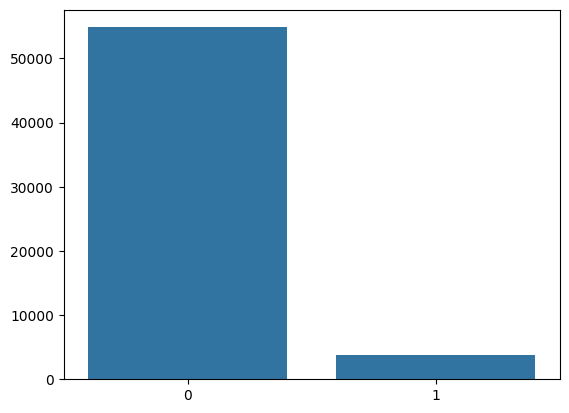

In [ ]:
sns.barplot(x = [0, 1], y = [54844, 3784])

# BASIC EDA

In [ ]:
data.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


In [ ]:
data.describe(include="all")

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,segment,fuel_type,max_torque,max_power,engine_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592,58592.000000,58592,58592,58592,58592,58592,...,58592,58592,58592,58592,58592,58592,58592,58592,58592.000000,58592.000000
unique,NaN,NaN,NaN,22,NaN,6,3,9,9,11,...,2,2,2,2,2,2,2,2,NaN,NaN
top,NaN,NaN,NaN,C8,NaN,B2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,F8D Petrol Engine,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,NaN,NaN
freq,NaN,NaN,NaN,13654,NaN,18314,20532,17796,17796,14948,...,32177,42435,42435,57383,34291,36309,42435,58229,NaN,NaN
mean,0.611246,0.069424,0.469420,NaN,18826.858667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.759950,0.063968
std,0.414156,0.056721,0.122886,NaN,17660.174792,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.389576,0.244698
min,0.002735,0.000000,0.288462,NaN,290.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,0.210250,0.020000,0.365385,NaN,6112.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,0.573792,0.060000,0.451923,NaN,8794.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000
75%,1.039104,0.110000,0.548077,NaN,27003.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000


# UNIVARIANT ANALYSIS

In [ ]:
target_obj = object_data.columns.to_list()
target_obj

['area_cluster',
 'segment',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [ ]:
target_num = numerical_data.columns.to_list()
target_num

['policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'population_density',
 'airbags',
 'displacement',
 'cylinder',
 'gear_box',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'ncap_rating',
 'is_claim']

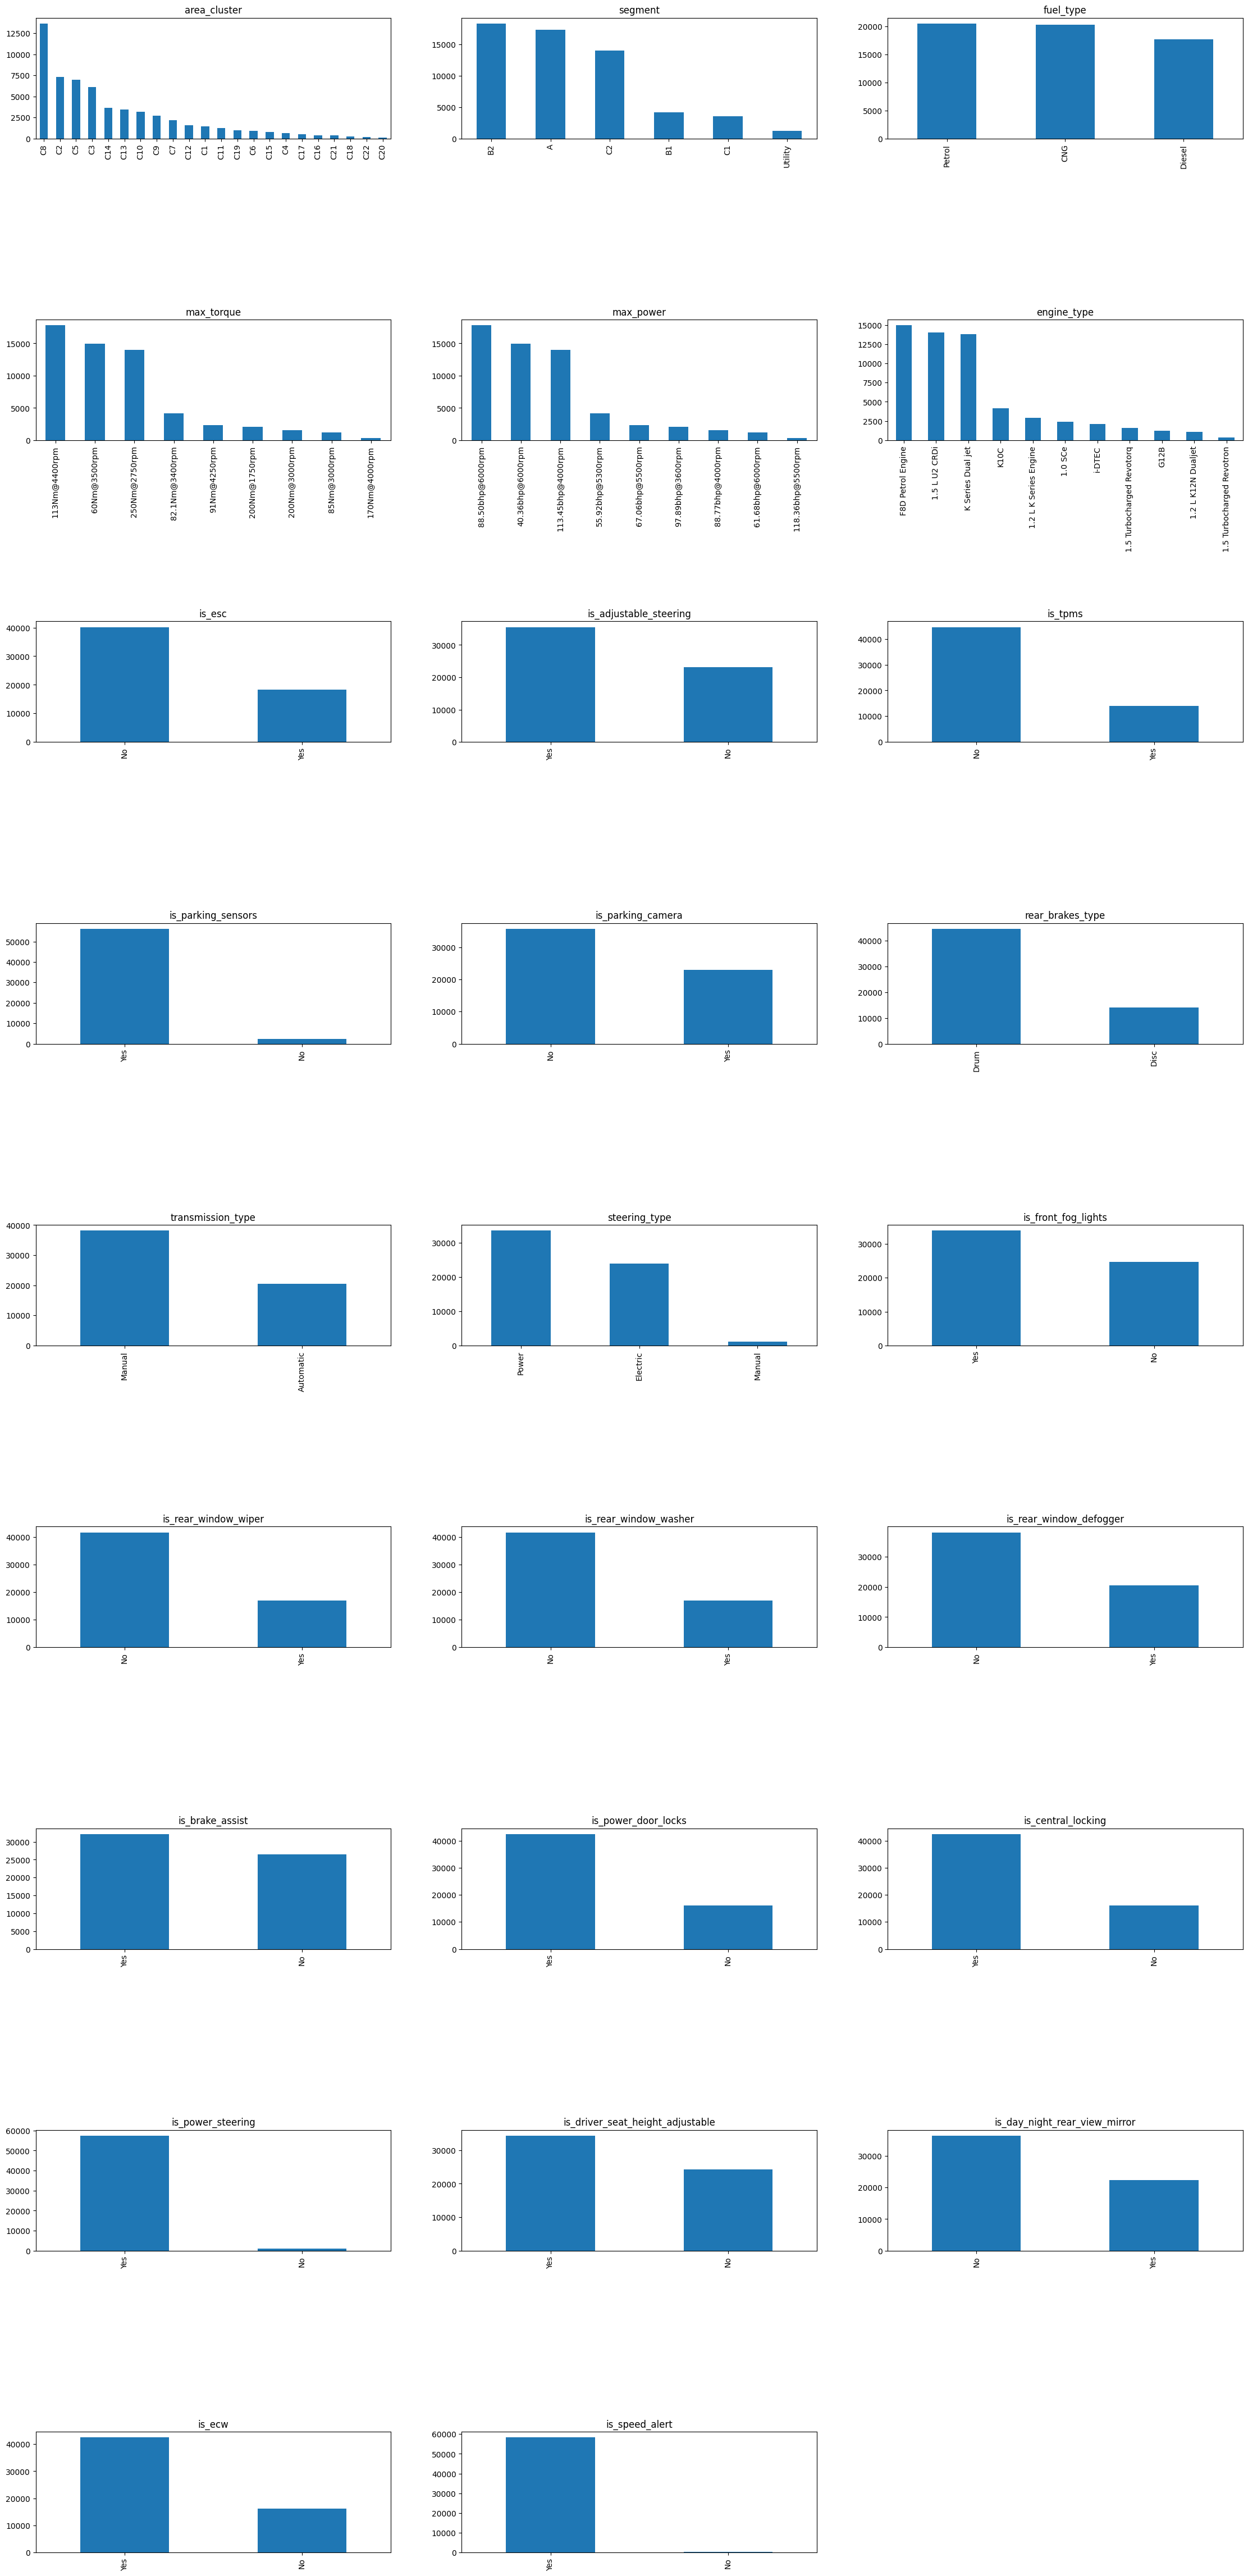

In [ ]:
plt.figure(figsize=(20,8))
row = 14
col=3
iterator=1
for i in  target_obj:
    plt.subplots_adjust(left=None, bottom=1, right=1.2, top=10, wspace=None, hspace=1.5)
    plt.subplot(row,col,iterator)
    data[i].value_counts().plot(kind='bar')
    plt.title(i)
    iterator+=1
    plt.xticks(rotation=90)

plt.show()

<ipython-input-22-a20d23218cac>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[i])
<ipython-input-22-a20d23218cac>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[i])
<ipython-input-22-a20d23218cac>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn

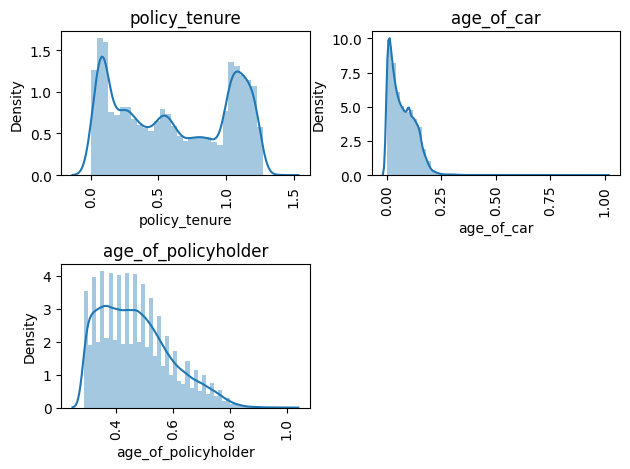

In [ ]:
n=['policy_tenure', 'age_of_car', 'age_of_policyholder']
rows=2
columns=2
iterator=1

for i in n:
    plt.subplot(rows,columns,iterator)
    sns.distplot(data[i])
    plt.title(i)
    iterator=iterator+1
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

<ipython-input-23-d38c668c6b1c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True)


<Axes: >

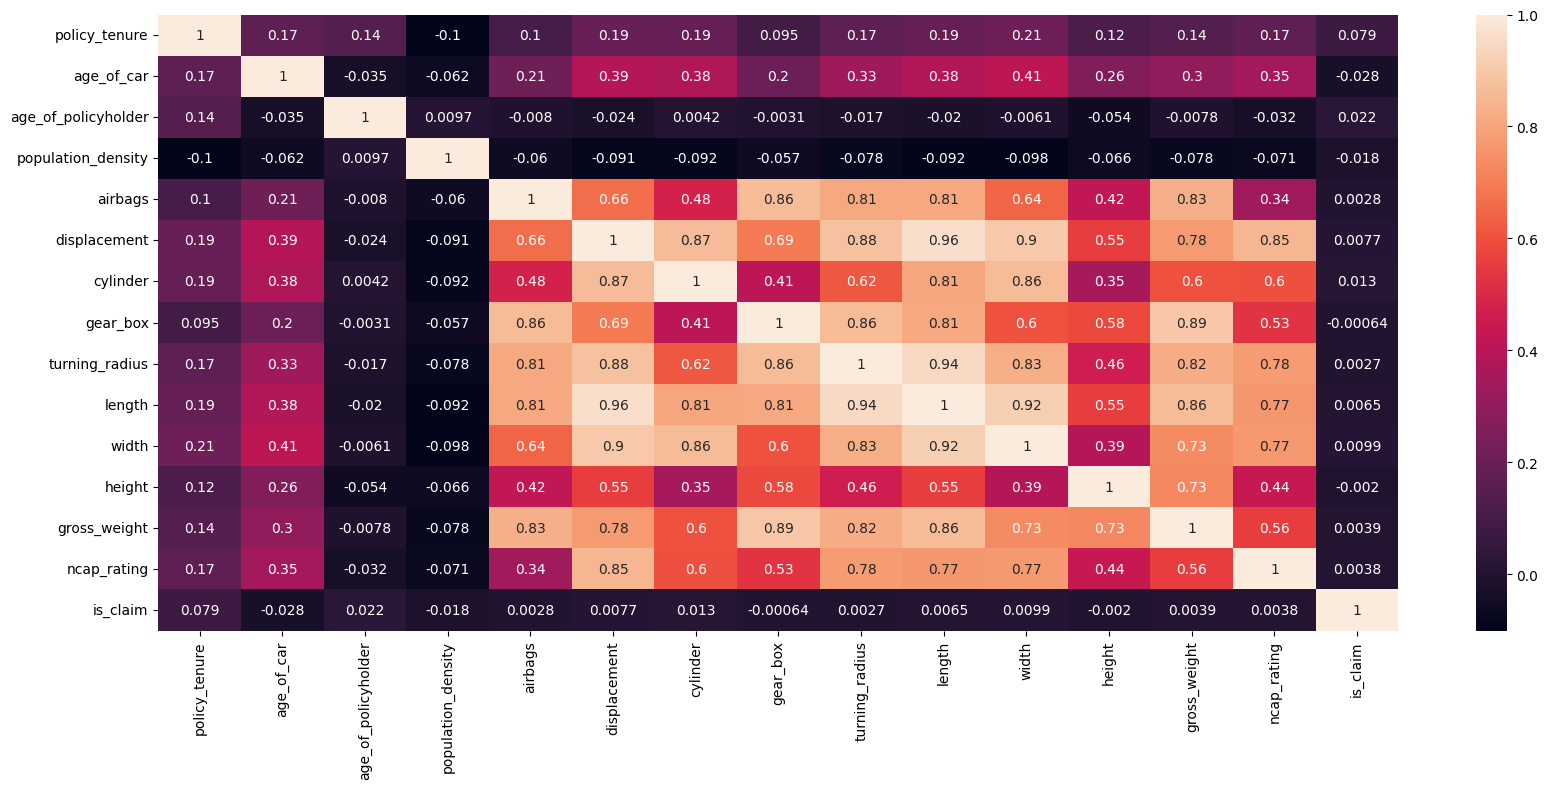

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(data.corr(),annot=True)

## ENCODING

In [ ]:
numerical_data=data.select_dtypes(["float64","int64"])
numerical_data.columns

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'airbags', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'ncap_rating', 'is_claim'],
      dtype='object')

In [ ]:

object_data=data.select_dtypes(["object"])
object_data.columns

Index(['area_cluster', 'segment', 'fuel_type', 'max_torque', 'max_power',
       'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms',
       'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
       'transmission_type', 'steering_type', 'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert'],
      dtype='object')

In [ ]:
categorical_data=pd.get_dummies(object_data)
categorical_data

,area_cluster_C1,area_cluster_C10,area_cluster_C11,area_cluster_C12,area_cluster_C13,area_cluster_C14,area_cluster_C15,area_cluster_C16,area_cluster_C17,area_cluster_C18,...,is_power_steering_No,is_power_steering_Yes,is_driver_seat_height_adjustable_No,is_driver_seat_height_adjustable_Yes,is_day_night_rear_view_mirror_No,is_day_night_rear_view_mirror_Yes,is_ecw_No,is_ecw_Yes,is_speed_alert_No,is_speed_alert_Yes
0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,1
58588,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
58589,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
58590,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1


In [ ]:
data=pd.concat([numerical_data,categorical_data],axis=1)

In [ ]:
X=data.drop("is_claim",axis=1)
y=data["is_claim"]

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

In [ ]:
y_res.value_counts()

0    54844
1    54844
Name: is_claim, dtype: int64

In [ ]:
new=pd.concat([X_res,y_res],axis=1)
new

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,displacement,cylinder,gear_box,turning_radius,length,...,is_power_steering_Yes,is_driver_seat_height_adjustable_No,is_driver_seat_height_adjustable_Yes,is_day_night_rear_view_mirror_No,is_day_night_rear_view_mirror_Yes,is_ecw_No,is_ecw_Yes,is_speed_alert_No,is_speed_alert_Yes,is_claim
0,0.515874,0.05,0.644231,4990,2,796,3,5,4.60,3445,...,1,1,0,1,0,1,0,0,1,0
1,0.672619,0.02,0.375000,27003,2,796,3,5,4.60,3445,...,1,1,0,1,0,1,0,0,1,0
2,0.841110,0.02,0.384615,4076,2,796,3,5,4.60,3445,...,1,1,0,1,0,1,0,0,1,0
3,0.900277,0.11,0.432692,21622,2,1197,4,5,4.80,3995,...,1,0,1,0,1,0,1,0,1,0
4,0.596403,0.11,0.634615,34738,2,999,3,5,5.00,3731,...,1,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109683,0.527062,0.03,0.317308,27003,2,998,3,5,4.70,3655,...,1,1,0,1,0,0,1,0,1,1
109684,1.093713,0.02,0.298077,27003,6,1197,4,5,4.85,3990,...,1,0,1,0,1,0,1,0,1,1
109685,1.008965,0.16,0.365385,8794,2,1197,4,5,4.80,3845,...,1,0,1,0,1,0,1,0,1,1
109686,0.403801,0.20,0.423077,8794,2,1197,4,5,4.80,3845,...,1,0,1,0,1,0,1,0,1,1


In [ ]:
n=new.drop("is_claim",axis=1)
n1=new["is_claim"]

# FEATURE SELECTION

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
r_f=SelectKBest(score_func=chi2,k=115)
o_f=r_f.fit(n,n1)

In [ ]:
o_f.scores_

array([7.12998553e+02, 1.73467876e+01, 6.77377979e+00, 2.69214205e+06,
       2.09540548e+00, 1.24093627e+03, 4.40699394e+00, 1.88017369e-02,
       2.72049992e-02, 3.65887802e+02, 2.83764493e+02, 8.13401265e+00,
       1.76835756e+02, 5.34430051e+00, 3.25030012e+01, 1.50094237e+02,
       5.57603687e+00, 2.32675391e+01, 2.95134239e+01, 8.58852459e+01,
       3.26278702e+01, 3.45945946e-01, 5.36193029e+01, 3.46963351e+01,
       1.07343832e+01, 5.42625929e+01, 2.60215054e+00, 6.71502591e+00,
       8.18181818e+00, 4.16193955e+01, 8.73053892e+00, 4.00478869e+01,
       7.29355033e-02, 4.62982172e+01, 5.44886483e+01, 8.11382468e+01,
       2.40593806e+01, 1.58425396e+01, 4.88054246e+01, 3.34140070e-01,
       6.09802576e-04, 1.31469793e+00, 2.57569267e+01, 5.15484666e-01,
       1.83510437e+01, 4.53475480e+01, 1.98367347e+01, 1.60726243e+00,
       1.33867508e+01, 6.09802576e-04, 1.22416303e+01, 1.58425396e+01,
       1.31469793e+00, 2.04548487e+01, 6.09802576e-04, 1.98367347e+01,
      

In [ ]:
dfscores=pd.DataFrame(o_f.scores_,columns=["Score"])
dfcolumns=pd.DataFrame(X.columns)

In [ ]:
features=pd.concat([dfcolumns,dfscores],axis=1)

In [ ]:
features

,0,Score
0,policy_tenure,7.129986e+02
1,age_of_car,1.734679e+01
2,age_of_policyholder,6.773780e+00
3,population_density,2.692142e+06
4,airbags,2.095405e+00
...,...,...
110,is_day_night_rear_view_mirror_Yes,1.810525e+01
111,is_ecw_No,1.353478e+01
112,is_ecw_Yes,5.025078e+00
113,is_speed_alert_No,1.983673e+01


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(n,n1,test_size=0.25,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model=RandomForestClassifier()
RF_model.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
default_model=RF_model.predict(x_test)

In [ ]:
default_model

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
#Creating the Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cm= confusion_matrix(y_test, default_model)

In [ ]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5)

In [ ]:
print("Cross validation scores with KFold")
cross_val_score(RF_model,x_train,y_train.values.reshape(-1,),cv=kf)
print("Cross validation scores with KFold mean.")
cross_val_score(RF_model,x_train,y_train.values.reshape(-1,),cv=kf).mean()

Cross validation scores with KFold
Cross validation scores with KFold mean.


KeyboardInterrupt: 

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [ ]:
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)

In [ ]:
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(RF_model,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.9688743185501696

Accuracy   : 0.9810371234774998
Precision : 0.963034051325798
Recall    : 1.0
F1-score  : 0.9811689722604476
Training data Confusion Matrix : 
 [[13355   520]
 [    0 13547]]


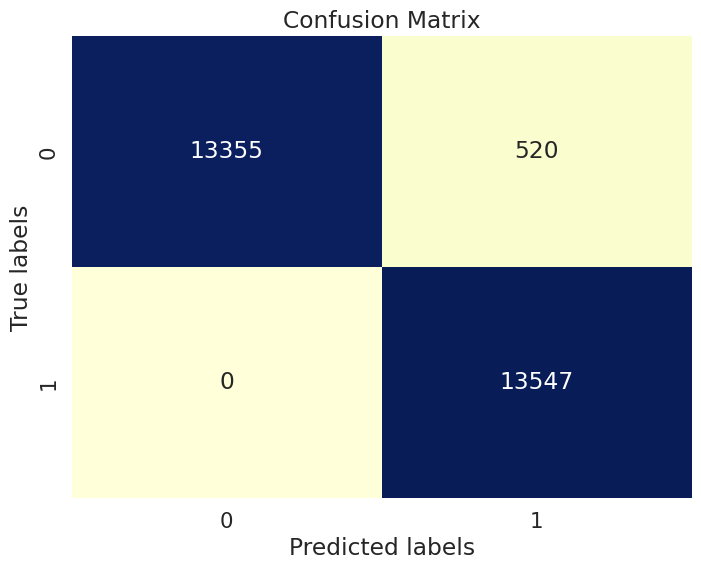

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

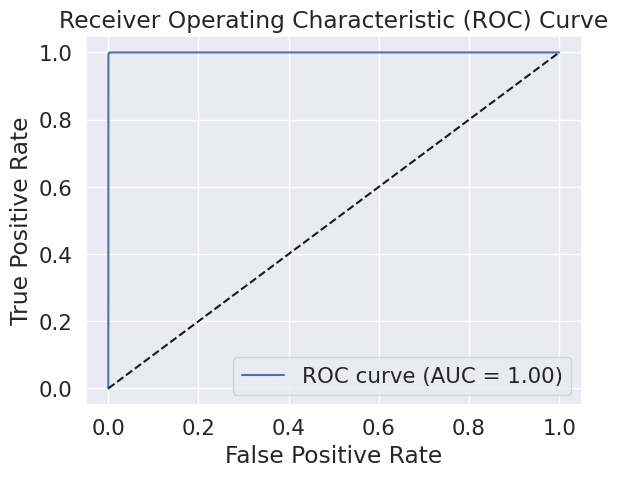

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = RF_model.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **Logistic**

Accuracy   : 0.515097367077529
Precision : 0.507178957041121
Recall    : 0.6518786447183879
F1-score  : 0.5704964630640524
Training data Confusion Matrix : 
 [[5294 8581]
 [4716 8831]]


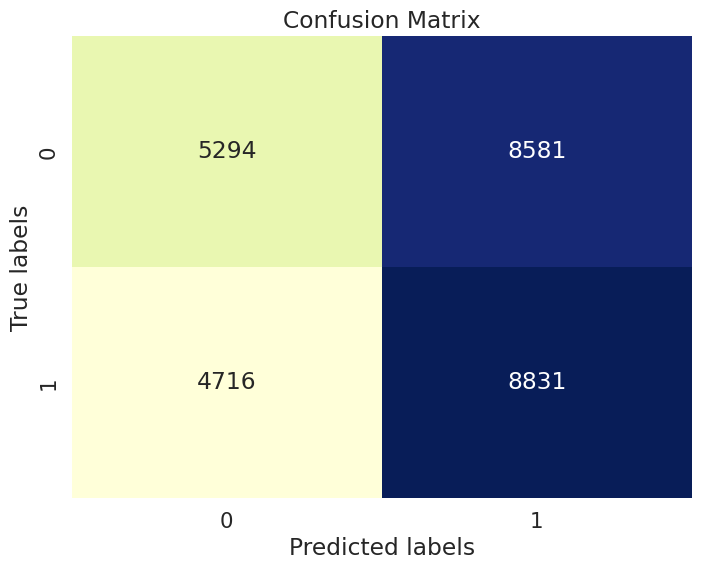

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

default_model=logreg.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(logreg,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.5158464711949315

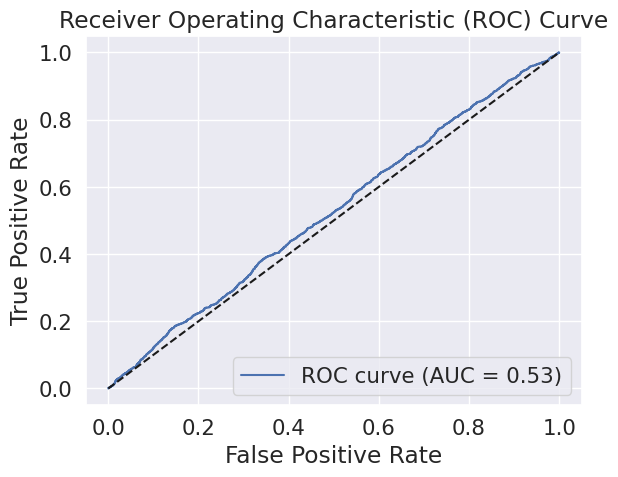

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = logreg.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **Decision**

Accuracy   : 0.9565677193494274
Precision : 0.9191884923327452
Recall    : 1.0
F1-score  : 0.9578928760827293
Training data Confusion Matrix : 
 [[12684  1191]
 [    0 13547]]


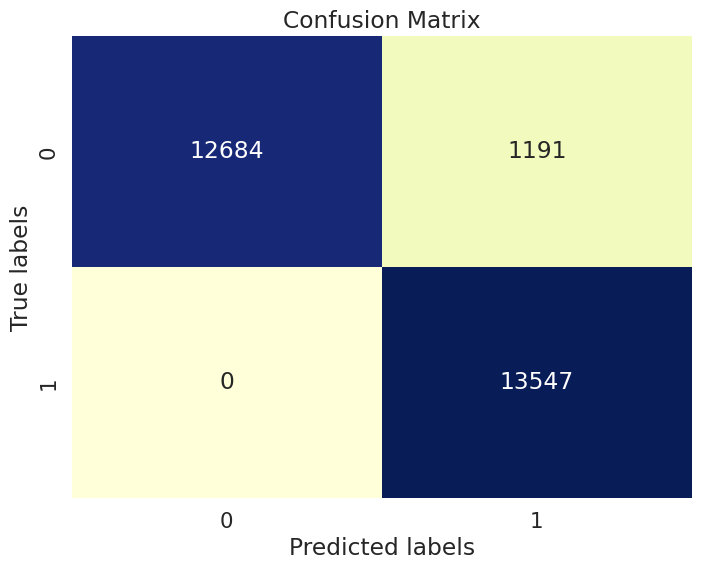

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dec = DecisionTreeClassifier()
dec.fit(x_train,y_train)

default_model=dec.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(dec,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.9405481066745247

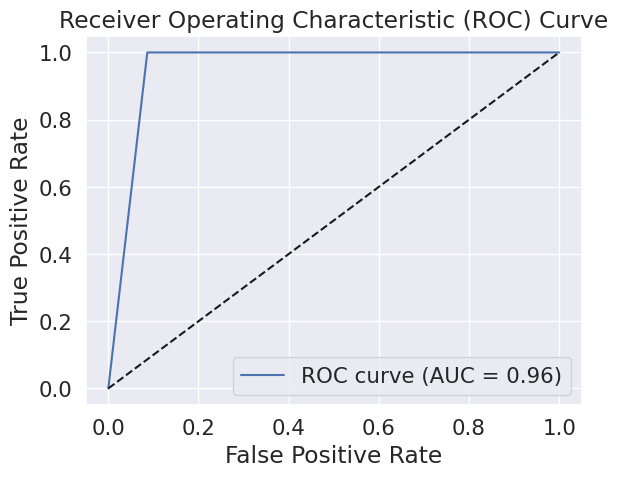

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = dec.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **KNN**

Accuracy   : 0.8880096273065422
Precision : 0.8158846942467736
Recall    : 0.9986712925370931
F1-score  : 0.8980716253443526
Training data Confusion Matrix : 
 [[10822  3053]
 [   18 13529]]


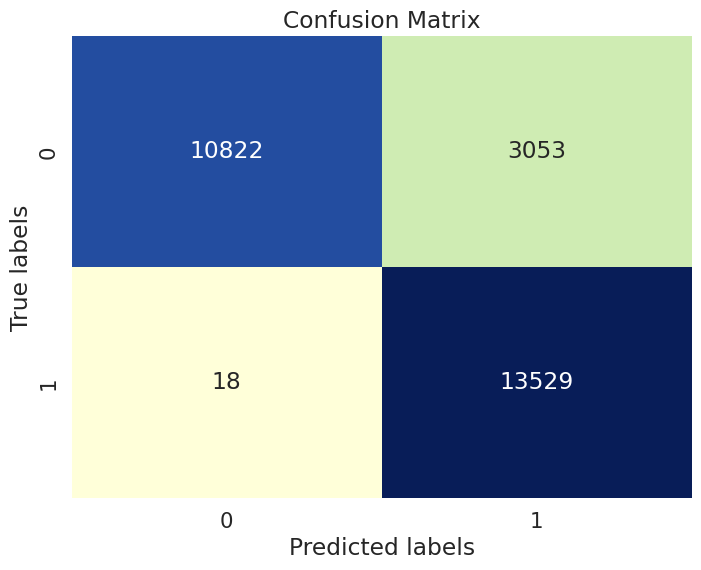

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

default_model=knn.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(knn,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.842375128922941

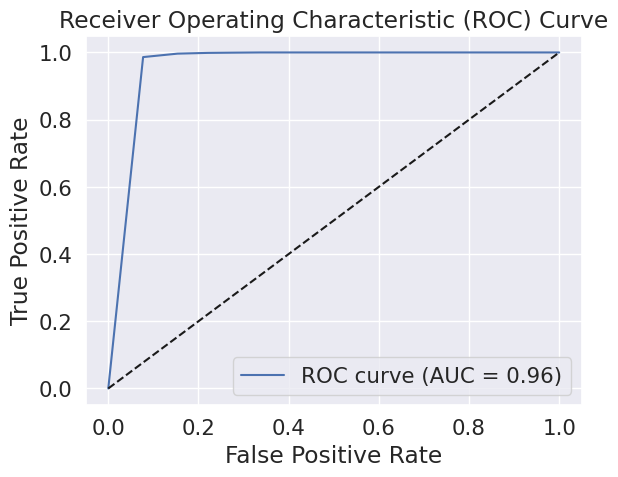

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = knn.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Naive Bayes **Classifier**

Accuracy   : 0.5240317992852455
Precision : 0.5149375339489408
Recall    : 0.6298073374178785
F1-score  : 0.5666091114357816
Training data Confusion Matrix : 
 [[5838 8037]
 [5015 8532]]


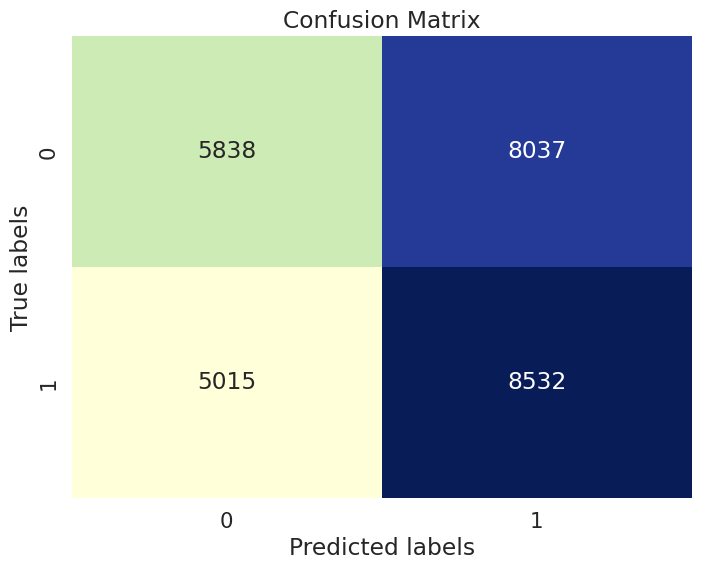

In [ ]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(x_train,y_train)

default_model=naive_bayes.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(naive_bayes,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.5279136584647119

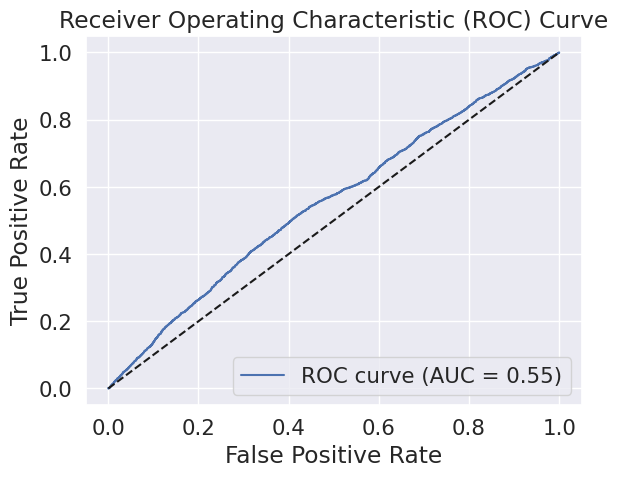

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = naive_bayes.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **MLP classifier**

Accuracy   : 0.49719203559186054
Precision : 0.4955634917712897
Recall    : 0.9935779139292832
F1-score  : 0.6612950771347156
Training data Confusion Matrix : 
 [[  174 13701]
 [   87 13460]]


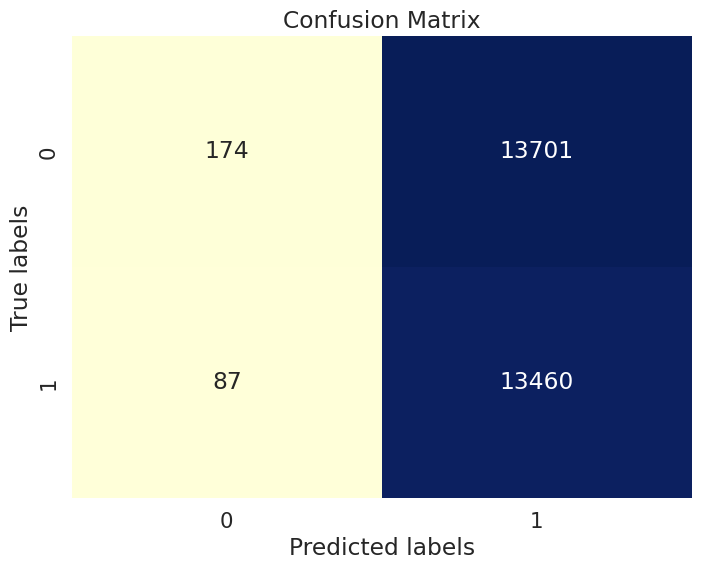

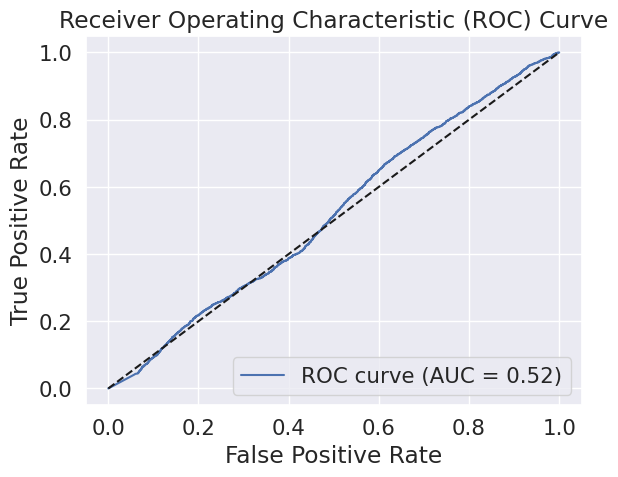

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)

default_model=mlp.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = mlp.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(mlp,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.5016944157949019

# **Adaboost classifier**

Accuracy   : 0.6099117496900299
Precision : 0.5901328273244781
Recall    : 0.6887133682734184
F1-score  : 0.6356235310147493
Training data Confusion Matrix : 
 [[7395 6480]
 [4217 9330]]


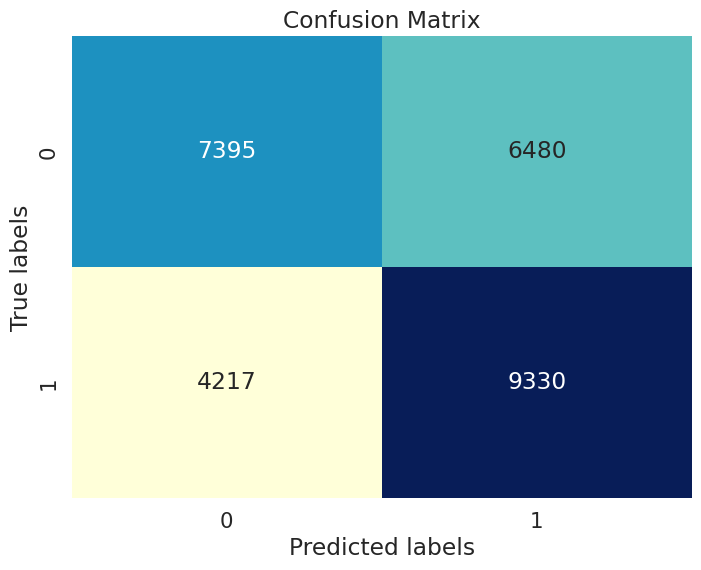

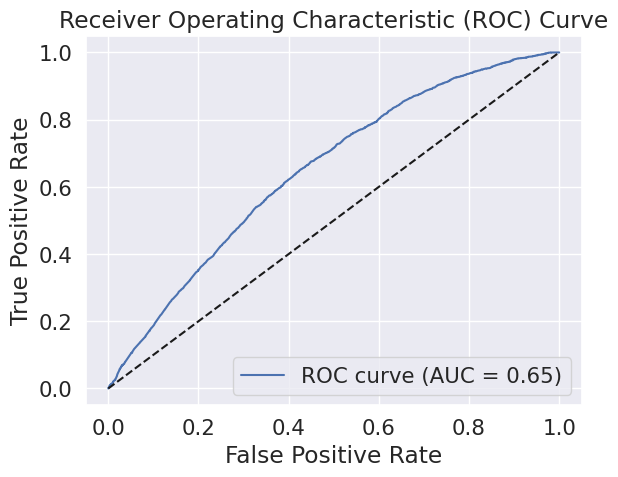

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x_train,y_train)

default_model=ada.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = ada.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(ada,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.6137174009135111

# **LGBM**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 41297, number of negative: 40969
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 82266, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501994 -> initscore=0.007974
[LightGBM] [Info] Start training from score 0.007974
Accuracy   : 0.7027204434395741
Precision : 0.6633957235447332
Recall    : 0.8084446740975861
F1-score  : 0.7287729571466596
Training data Confusion Matrix : 
 [[ 8318  5557]
 [ 2595 10952]]


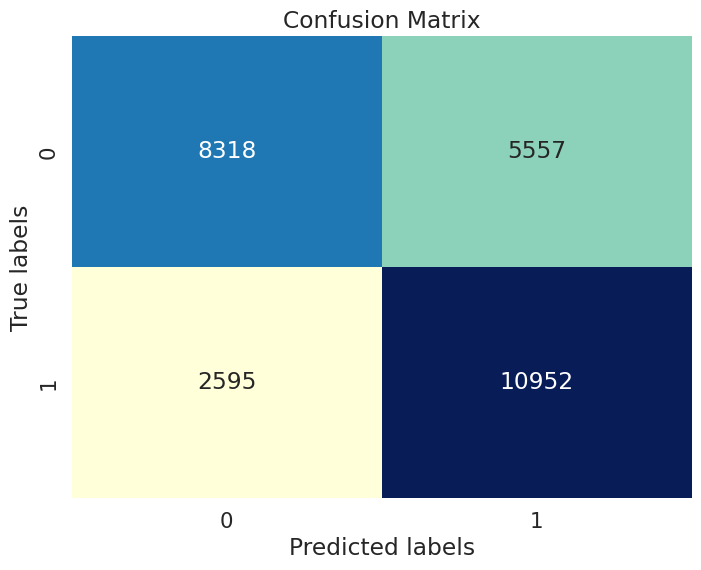

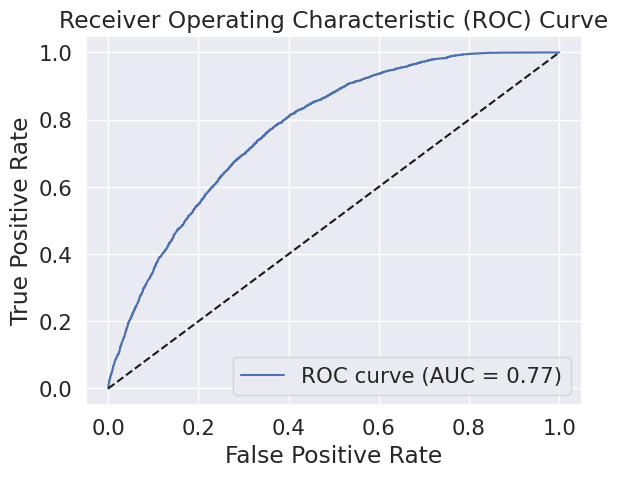

In [ ]:
from lightgbm import LGBMClassifier
lgbm=LGBMClassifier(force_col_wise=True)
lgbm.fit(x_train,y_train)

default_model=lgbm.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = lgbm.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(lgbm,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27775, number of negative: 27343
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 55118, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503919 -> initscore=0.015676
[LightGBM] [Info] Start training from score 0.015676
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27588, number of negative: 27530
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 55118, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500526 -> initscore=0.002105
[LightGBM] [Info] Start training from score 0.002105
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2761

0.7023132459113011

# **Gradient Boosting**

Accuracy   : 0.6304791773028955
Precision : 0.6075478830645161
Recall    : 0.7118181147117443
F1-score  : 0.6555627315680342
Training data Confusion Matrix : 
 [[7646 6229]
 [3904 9643]]


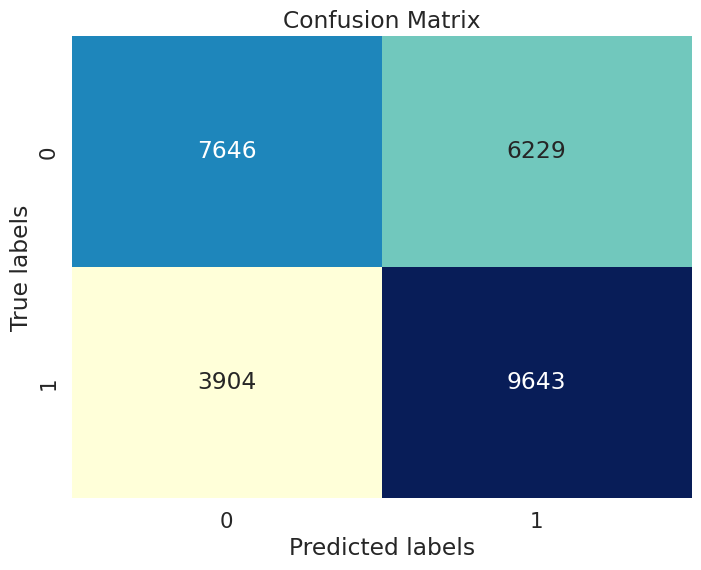

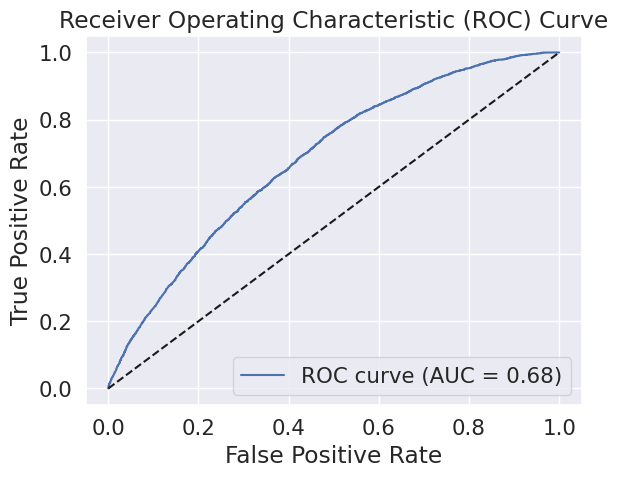

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(x_train,y_train)

default_model=gbc.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = gbc.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(gbc,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Cross validation scores with Monte Carlo Cross Validation


0.6417489317813467

# **Catboost**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.7 MB/s eta 0:00:00
Learning rate set to 0.067723
0:	learn: 0.6877470	total: 74.7ms	remaining: 1m 14s
1:	learn: 0.6832147	total: 100ms	remaining: 49.9s
2:	learn: 0.6790005	total: 123ms	remaining: 41s
3:	learn: 0.6755313	total: 148ms	remaining: 36.9s
4:	learn: 0.6722680	total: 176ms	remaining: 35.1s
5:	learn: 0.6695344	total: 201ms	remaining: 33.3s
6:	learn: 0.6670853	total: 227ms	remaining: 32.1s
7:	learn: 0.6650997	total: 253ms	remaining: 31.4s
8:	learn: 0.6630592	total: 281ms	remaining: 30.9s
9:	learn: 0.6613560	total: 307ms	remaining: 30.4s
10:	learn: 0.6597321	total: 332ms	remaining: 29.9s
11:	learn: 0.6582307	total: 358ms	remaining: 29.5s
12:	learn: 0.6568207	total: 387ms	remaining: 29.4s
13:	learn: 0.6556655	total: 416ms	remaining: 29.3s
14:	learn: 0.6547106	total: 441ms	remaining: 28.9s
15:	learn: 0.6538208	total: 476ms	remaining: 29.3s
16:	learn: 0.6528441	total: 503ms	remaining: 29.1s
17:	learn: 0.6520760	total: 527ms

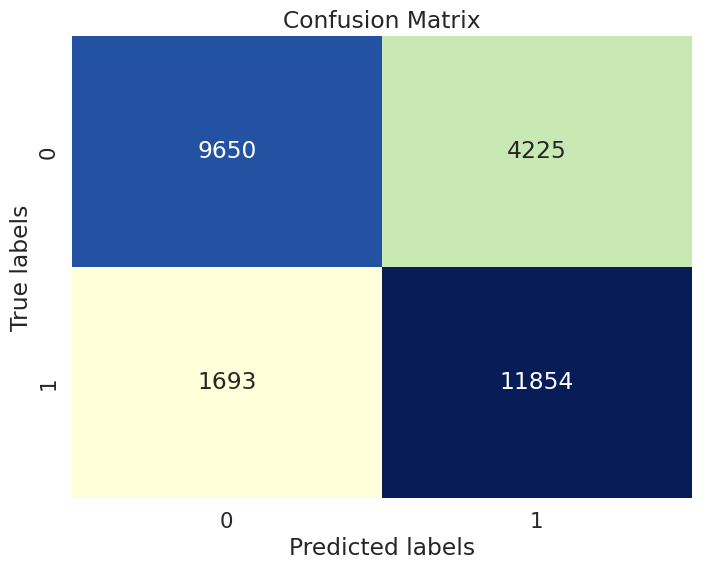

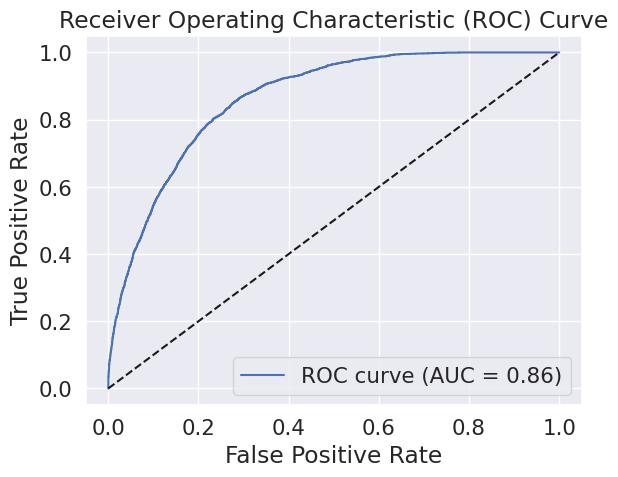

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

cat = CatBoostClassifier()
cat.fit(x_train,y_train)

default_model=cat.predict(x_test)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming default_model is the model predictions
# y_test is the ground truth labels

accuracy = accuracy_score(y_test, default_model)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, default_model)
print("Precision :", precision)
recall = recall_score(y_test, default_model)
print("Recall    :", recall)
F1_score = f1_score(y_test, default_model)
print("F1-score  :", F1_score)

conf_matrix = confusion_matrix(y_test, default_model)
print("Training data Confusion Matrix : \n", conf_matrix)

# Plotting the confusion matrix
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = cat.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from  sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
mc=ShuffleSplit(n_splits=5,test_size=0.33,random_state=7)
print("Cross validation scores with Monte Carlo Cross Validation")
cross_val_score(cat,x_train,y_train.values.reshape(-1,),cv=mc).mean()

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6754300	total: 95.5ms	remaining: 19s
5:	learn: 0.6728010	total: 113ms	remaining: 18.8s
6:	learn: 0.6704382	total: 131ms	remaining: 18.6s
7:	learn: 0.6684726	total: 149ms	remaining: 18.5s
8:	learn: 0.6665247	total: 168ms	remaining: 18.5s
9:	learn: 0.6649151	total: 189ms	remaining: 18.7s
10:	learn: 0.6632869	total: 207ms	remaining: 18.6s
11:	learn: 0.6618560	total: 226ms	remaining: 18.6s
12:	learn: 0.6607289	total: 243ms	remaining: 18.4s
13:	learn: 0.6595815	total: 260ms	remaining: 18.3s
14:	learn: 0.6582968	total: 279ms	remaining: 18.3s
15:	learn: 0.6573449	total: 297ms	remaining: 18.2s
16:	learn: 0.6562477	total: 316ms	remaining: 18.3s
17:	learn: 0.6552017	total: 335ms	remaining: 18.3s
18:	learn: 0.6543789	total: 352ms	remaining: 18.2s
19:	learn: 0.6534445	total: 372ms	remaining: 18.3s
20:	learn: 0.6526689	total: 395ms	remaining: 18.4s
21:	learn: 0.6520789	total: 414ms	remaining: 18.4s
22:	learn: 0.6514151	total: 432ms	rema

0.7641741564756152

# **roc auc for all**

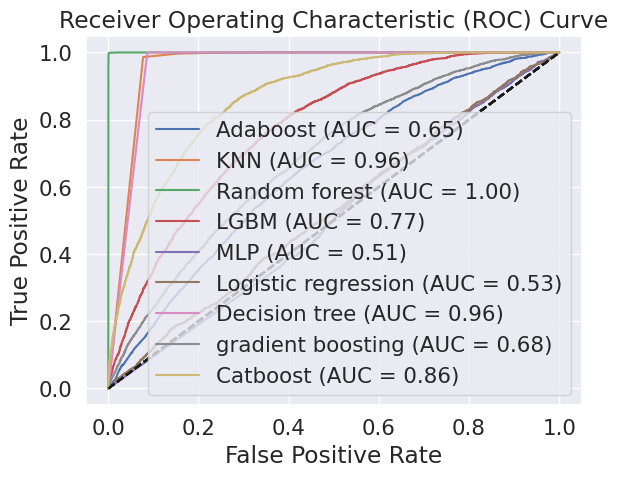

In [ ]:
y_pred_proba = ada.predict_proba(x_test)[:, 1]   #adaboost

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Adaboost (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

y_pred_proba = knn.predict_proba(x_test)[:, 1] #knn

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='KNN (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


y_pred_proba = RF_model.predict_proba(x_test)[:, 1] #random forest

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Random forest (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


y_pred_proba = lgbm.predict_proba(x_test)[:, 1] #lgbm

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='LGBM (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

y_pred_proba = mlp.predict_proba(x_test)[:, 1]  #mlp

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='MLP (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

y_pred_proba = logreg.predict_proba(x_test)[:, 1] #logistic

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Logistic regression (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

y_pred_proba = dec.predict_proba(x_test)[:, 1] #decision tree

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Decision tree (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


y_pred_proba = gbc.predict_proba(x_test)[:, 1] #gradient boosting

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='gradient boosting (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

y_pred_proba = cat.predict_proba(x_test)[:, 1]   #catboost

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Catboost (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend()

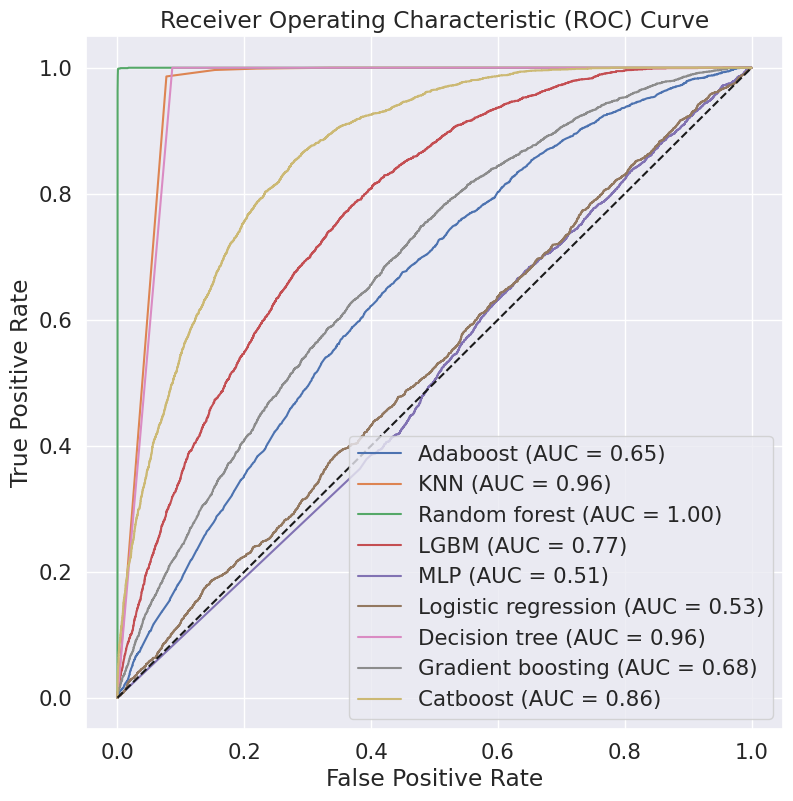

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_test contains the ground truth labels

plt.figure(figsize=(9,9))  # Increase the size of the figure

# Adaboost
y_pred_proba = ada.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Adaboost (AUC = %0.2f)' % auc)

# KNN
y_pred_proba = knn.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='KNN (AUC = %0.2f)' % auc)

# Random Forest
y_pred_proba = RF_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Random forest (AUC = %0.2f)' % auc)

# LGBM
y_pred_proba = lgbm.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='LGBM (AUC = %0.2f)' % auc)

# MLP
y_pred_proba = mlp.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='MLP (AUC = %0.2f)' % auc)

# Logistic Regression
y_pred_proba = logreg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic regression (AUC = %0.2f)' % auc)

# Decision Tree
y_pred_proba = dec.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Decision tree (AUC = %0.2f)' % auc)

# Gradient Boosting
y_pred_proba = gbc.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Gradient boosting (AUC = %0.2f)' % auc)

# Catboost
y_pred_proba = cat.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Catboost (AUC = %0.2f)' % auc)

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


# random forest has highest accuracy

In [ ]:
import pandas as pd

# Sample data
print("Machine Learning and Deep Learning Algorithms :")
print()
data = {
    'Model' :['Logistic regression','Random forest','Decision tree','Catboost','Adaboost','Gradient Boosting','LGBM','MLP','KNN','Naive Bayes','ANN'],
    'Accuracy': ['0.51', '0.98','0.95','0.78','0.60','0.63','0.70','0.50','0.88','0.52','0.93'],
    'Precision': ['0.50','0.96','0.92','0.73','0.59','0.60','0.66','0.50','0.81','0.51','0.94'],
    'F1': ['0.57','0.98','0.95','0.80','0.63','0.65','0.72','0.66','0.89','0.56','0.97'] ,
    'Recall': ['0.65','0.99','0.99','0.87','0.68','0.71','0.80','0.97','0.99','0.62','0.99']
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


Machine Learning and Deep Learning Algorithms :

                  Model Accuracy Precision    F1 Recall
0   Logistic regression     0.51      0.50  0.57   0.65
1         Random forest     0.98      0.96  0.98   0.99
2         Decision tree     0.95      0.92  0.95   0.99
3              Catboost     0.78      0.73  0.80   0.87
4              Adaboost     0.60      0.59  0.63   0.68
5     Gradient Boosting     0.63      0.60  0.65   0.71
6                  LGBM     0.70      0.66  0.72   0.80
7                   MLP     0.50      0.50  0.66   0.97
8                   KNN     0.88      0.81  0.89   0.99
9           Naive Bayes     0.52      0.51  0.56   0.62
10                  ANN     0.93      0.94  0.97   0.99


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))

In [ ]:
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))

In [ ]:
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [ ]:
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
ann.fit(x_train,y_train,batch_size=32,epochs = 20)

Epoch 1/20
2571/2571 [==============================] - 12s 5ms/step - loss: 0.6932 - accuracy: 0.5009
Epoch 2/20
2571/2571 [==============================] - 6s 2ms/step - loss: 0.6932 - accuracy: 0.4991
Epoch 3/20
2571/2571 [==============================] - 6s 2ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/20
2571/2571 [==============================] - 6s 2ms/step - loss: 0.6932 - accuracy: 0.5012
Epoch 5/20
2571/2571 [==============================] - 6s 2ms/step - loss: 0.6932 - accuracy: 0.4990
Epoch 6/20
2571/2571 [==============================] - 10s 4ms/step - loss: 0.6932 - accuracy: 0.5002
Epoch 7/20
2571/2571 [==============================] - 9s 4ms/step - loss: 0.6932 - accuracy: 0.5024
Epoch 8/20
2571/2571 [==============================] - 9s 4ms/step - loss: 0.6932 - accuracy: 0.4973
Epoch 9/20
2571/2571 [==============================] - 14s 6ms/step - loss: 0.6932 - accuracy: 0.5014
Epoch 10/20
2571/2571 [==============================] - 14s 5ms/step - loss: 0

KeyboardInterrupt: 

In [ ]:
# Making predictions
y_train_pred = ann.predict(x_train)
y_test_pred  = ann.predict(x_test)

857/857 [==============================] - 1s 1ms/step


In [ ]:
train_acc = accuracy_score(y_train, y_train_pred.round(),normalize=False)
test_acc = accuracy_score(y_test, y_test_pred.round(), normalize=False)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
print('Training data accuracy score \n\n',accuracy_score(y_train, y_train_pred.round()))
print('\n')
print('Testing data accuracy score \n\n',accuracy_score(y_test, y_test_pred.round()))
print('\n')
print('Training data Classification Report \n\n',classification_report(y_train, y_train_pred.round()))
print('\n')
print('Testing data Classification Report \n\n',classification_report(y_test, y_test_pred.round()))
print('\n')
print ("Training data Confusion Matrix : \n", confusion_matrix(y_train, y_train_pred.round()))
print('\n')
print ("Testing data Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred.round()))

Training data accuracy score 

 0.5019935331728782


Testing data accuracy score 

 0.49401940048136533




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training data Classification Report 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00     40969
           1       0.50      1.00      0.67     41297

    accuracy                           0.50     82266
   macro avg       0.25      0.50      0.33     82266
weighted avg       0.25      0.50      0.34     82266



Testing data Classification Report 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00     13875
           1       0.49      1.00      0.66     13547

    accuracy                           0.49     27422
   macro avg       0.25      0.50      0.33     27422
weighted avg       0.24      0.49      0.33     27422



Training data Confusion Matrix : 
 [[    0 40969]
 [    0 41297]]


Testing data Confusion Matrix : 
 [[    0 13875]
 [    0 13547]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif